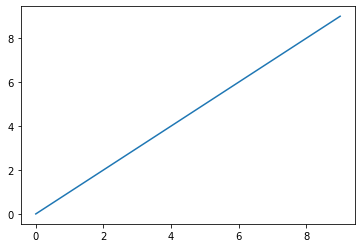

In [1]:
import matplotlib.pyplot as plt

plt.plot(range(10))
plt.show();

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [2]:
%%capture
%matplotlib inline
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

#Import and Subset

In [3]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv',
                 index_col='SALE DATE')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [4]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [5]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [6]:
# Create subset for only 'one family dwellings'
df = df[df['BUILDING_CLASS_CATEGORY']=='01 ONE FAMILY DWELLINGS']

In [7]:
# Further subset by sale price between 100,000 and 2,000,000
df = df.loc[(df['SALE_PRICE'] < 2000000) & (df['SALE_PRICE'] > 100000)]

In [8]:
df.isnull().sum()

BOROUGH                              0
NEIGHBORHOOD                         0
BUILDING_CLASS_CATEGORY              0
TAX_CLASS_AT_PRESENT                 0
BLOCK                                0
LOT                                  0
EASE-MENT                         3151
BUILDING_CLASS_AT_PRESENT            0
ADDRESS                              0
APARTMENT_NUMBER                  3150
ZIP_CODE                             0
RESIDENTIAL_UNITS                    0
COMMERCIAL_UNITS                     0
TOTAL_UNITS                          0
LAND_SQUARE_FEET                     0
GROSS_SQUARE_FEET                    0
YEAR_BUILT                           0
TAX_CLASS_AT_TIME_OF_SALE            0
BUILDING_CLASS_AT_TIME_OF_SALE       0
SALE_PRICE                           0
dtype: int64

In [9]:
# Remove null columns
df = df.drop(['EASE-MENT', 'APARTMENT_NUMBER'], axis=1)

In [10]:
# Drop high cardinality columns
hc_cols = [col for col in df.select_dtypes('object').columns if df[col].nunique() > 15]
df = df.drop(hc_cols, axis=1)

In [11]:
# Confirm subset worked

#df['SALE_PRICE'].describe()
#df['BUILDING_CLASS_CATEGORY'].value_counts()
df.shape

(3151, 16)

In [12]:
df.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
BUILDING_CLASS_AT_PRESENT          object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
dtype: object

#Split Data

In [13]:
# Time Series split Jan-Mar for train, Apr for test
# Create target variable and feature matrix
target = 'SALE_PRICE'
y = df[target]
X = df.drop(columns=target)

# Create mask for time series split
mask = df.index < '04/01/2019'
# Apply mask to split data
X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

#One Hot Encoding

In [14]:
from category_encoders import OneHotEncoder
# Instantiate
ohe = OneHotEncoder(use_cat_names=True)

# Fit to ALL data (ONLY ONCE)
ohe.fit(X_train)
ohe.fit(X_test);

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [15]:
# Transform Data
XT_train = ohe.transform(X_train)
XT_test = ohe.transform(X_test)

In [16]:
# View all new columns
XT_train

,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A3
SALE DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01/01/2019,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,5495,801,0,0,0,1,0,0,0,0,0,0,0,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,0,0,0,1,0,0,0,0,0,0
01/01/2019,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,7918,72,1,0,0,0,0,0,0,0,0,0,0,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,1,0,0,0,0,0,0,0,0,0
01/02/2019,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,4210,19,1,0,0,0,0,0,0,0,0,0,0,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,1,0,0,0,0,0,0,0,0,0
01/02/2019,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,5212,69,1,0,0,0,0,0,0,0,0,0,0,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,1,0,0,0,0,0,0,0,0,0
01/02/2019,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,7930,121,0,0,1,0,0,0,0,0,0,0,0,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03/29/2019,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,4081,44,0,1,0,0,0,0,0,0,0,0,0,10306.0,1.0,0.0,1.0,921.0,1950.0,1,0,1,0,0,0,0,0,0,0,0
03/29/2019,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,2373,201,0,0,1,0,0,0,0,0,0,0,0,10314.0,1.0,0.0,1.0,2128.0,1980.0,1,0,0,1,0,0,0,0,0,0,0
03/29/2019,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1132,42,1,0,0,0,0,0,0,0,0,0,0,10302.0,1.0,0.0,1.0,1807.0,2018.0,1,1,0,0,0,0,0,0,0,0,0


#Feature Selection

In [56]:
from sklearn.feature_selection import SelectKBest
# Inatantiate
skb = SelectKBest(k=33)
# Fit onto the transformed data
skb.fit(XT_train, y_train)
# Transform data again
XTT_train = skb.transform(XT_train)
XTT_test = skb.transform(XT_test)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 4 12 34] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


#Ridge Model

In [70]:
from sklearn.linear_model import Ridge
# Instantiate
model_r = Ridge(alpha=.1, normalize=True) #default alpha=1 vs. alpha=10 vs. alpha=0.1
# Fit model to data
model_r.fit(XTT_train, y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

#Metrics

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [72]:
y_pred = [y.mean()] * len(y)
print('Baseline MAE:', mean_absolute_error(y, y_pred))

Baseline MAE: 215470.57403809385


In [73]:
print('Training MAE:', mean_absolute_error(y_train, model_r.predict(XTT_train)))
print('Test MAE:', mean_absolute_error(y_test, model_r.predict(XTT_test)))

Training MAE: 156114.76591759615
Test MAE: 159220.69299336462


In [74]:
print('Training RMSE:', mean_squared_error(y_train, model_r.predict(XTT_train), squared=False))
print('Test RMSE:', mean_squared_error(y_test, model_r.predict(XTT_test), squared=False))

Training RMSE: 218388.68355135934
Test RMSE: 232871.40267217936


In [75]:
print('Training R^2:', r2_score(y_train, model_r.predict(XTT_train)))
print('Test R^2:', r2_score(y_test, model_r.predict(XTT_test)))

Training R^2: 0.4389042671333505
Test R^2: 0.38418120297983716


In [62]:
## All results explained in communicate results section

#Visualizations

In [39]:
k_values = range(2, len(XT_train.columns), 2)

training_mae = []
test_mae = []

for k in k_values:
  #Transform
  skb = SelectKBest(k=k)
  skb.fit(XT_train, y_train)
  XTT_train = skb.transform(XT_train)
  XTT_test = skb.transform(XT_test)

  #Fit the model
  model_lr = LinearRegression()
  model_lr.fit(XTT_train, y_train)

  #Get metrics
  training_mae.append(mean_absolute_error(y_train, model_lr.predict(XTT_train)))
  test_mae.append(mean_absolute_error(y_test, model_lr.predict(XTT_test)));

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 4 12 34] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 4 12 34] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/l

In [40]:
import matplotlib.pyplot as plt

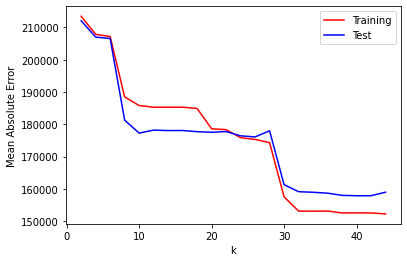

In [41]:
plt.plot(k_values, training_mae, c='r', label='Training')
plt.plot(k_values, test_mae, c='blue', label='Test')
plt.xlabel('k')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show();

#Communicate Results

##Mean Absolute Error

- We saw a large value of the mean absolute error of our ridge model (about \$174,000), but when compared to our baseline model (which had an mean error of $215,000) our model looks to have done a bit better of a job fitting within the data.

##Root Mean Squared Error

- Our mean squared error is pretty high at about \$215,000. This is showing us that there might be a large presence of biases or outliers in our data. But we can't be too sure due to scaling.

##$R^2$

- To further prove this claim, our $R^2$ value is pretty low at only 28%. Only 28% of the data is explained by our model. Through feature selection, we chose over 30 features to be represented as well but our data is still not very well represented by the model.

##Changing alpha value

- By increasing our alpha value from 1 to 10, our $R^2$ shoots up from 28-82%, however our error rises as well.

- Reducing alpha to 0.1 reduces our mean error, is, contrastingly, affected more by outliers yet covers more variance than alpha=1.